In [ ]:
# This is a notebook for looking at the different methods for identifying clustering.

In [1]:
# importing the neccessary modules

import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# reading in the csv file

csvarray = []
filelocation = '/Users/zack/Documents/Documents/csv_data_files/'
filename = 'test_case_20'
with open(filelocation + filename + '.csv', 'r') as csvfile:
    csv_data = list(csv.reader(csvfile, delimiter=","))
#print (csv_data[:3])
csvarray = np.array(csv_data[1:], dtype=np.float) # Remove headers and convert to floats
#print (csvarray[:3])

In [3]:
# Variables

x_len = 28.0 # Length of x axis
y_len = 16.0 # Length of y axis

# The following variables are pulled from the csv file

num_part = len(csvarray) # Number of particles
#print (num_part)
x = csvarray[:,7]
y = csvarray[:,8]
rad = np.mean(csvarray[:, 1])/2
#print (rad)

#print (x[:3])
#print (len(x))

In [4]:
# A function that creates an array of the particles within a set distance from the selected particle

def domain_reduction(arr, j, x, y, radius):
    arr_red = []
    x_pos = arr[j, x]
    y_pos = arr[j, y]
    #print (x_pos)
    for i in range(0, len(arr)):
        if arr[i, x] < x_pos + radius and arr[i, x] > x_pos - radius:
            if arr[i, y] < y_pos + radius and arr[i, y] > y_pos - radius:
                arr_red.append(arr[i])
    arr_red = np.array(arr_red)
    #print (arr_red)
    return arr_red
    

In [5]:
# Creating an array of the nearest neighbors and which particles are the nearest.

num_of_it = len(x)
#print (num_of_it)
min_array = []

for i in range(0, num_of_it):
    
    #if i % 100 == 0:
        #print (i)
    #print (i)    
    near_neigh = []
    #print (near_neigh)
    red_arr = domain_reduction(csvarray, i, 7, 8, 5) # Creating an array that is reduced to particles within a set radius.
    #print (len(red_arr))
    #print (red_arr)
    
    for n in range(0, len(red_arr)):
        if csvarray[i, 0] != red_arr[n, 0]:
            distance = np.sqrt((csvarray[i, 7] - red_arr[n, 7])**2 + (csvarray[i, 8] - red_arr[n, 8])**2) - \
            ((csvarray[i, 1]/2) + (red_arr[n, 1]/2))
            arr = np.array([csvarray[i, 0], red_arr[n, 0], distance])
            #print (arr)
            near_neigh.append(arr)
        
    near_neigh = np.array(near_neigh) # Converts the list into an array
    #print (near_neigh)
    min_dist = np.amin(near_neigh[:, 2])
    min_index = np.argmin(near_neigh[:, 2]) # Gives the index of the minimum value in the near_neigh array
    #print (min_index)
    min_array.append(near_neigh[min_index])
min_array = np.array(min_array)
#print (min_array)
        
            

In [6]:
# Writing nearest neighbor data to csv

tablename = 'minimum_distance'
with open(filelocation + tablename + filename + '.csv', 'w', newline='') as f:
    writer=csv.writer(f)
    writer.writerow(['original particle', 'nearest neighbor', 'distance'])
    writer.writerows(min_array)


In [7]:
# reading the nearest neighbor data from csv

with open(filelocation + tablename + filename + '.csv', 'r') as csvminfile:
    csv_min = list(csv.reader(csvminfile, delimiter=","))
#print (csv_data[:3])
min_array = np.array(csv_min[1:], dtype=np.float) # Remove headers and convert to floats
#print (csvarray[:3])

In [8]:
# Finding the mean distance rA

#print(min_array[:, 2])
rA = np.mean(min_array[:, 2])
print ("{:2.3f}".format(rA))

1.011


In [9]:
# Calculating rE the expected value

lam = num_part / ((x_len * y_len) - 20*(np.pi*rad**2)) # Intensity
print ("{:2.3f}".format(lam))

denom = 2 * np.sqrt(lam)
rE = 1 / (2 * np.sqrt(lam))
print ("{:2.2f}".format(rE))

0.046
2.32


In [10]:
# Calculating R

R = rA / rE
print ("{:2.2f}".format(R))


0.44


In [21]:
def part_in_rad(arr, part_num, x_val, y_val, radius):
    
    num_part = []
    
    for i in range(0, len(arr)):
        #print (i)
        dist = np.sqrt((arr[part_num, x_val] - arr[i, x_val])**2 + (arr[part_num, y_val] - arr[i, y_val])**2) - \
        (arr[part_num, 1]/2 + arr[i, 1]/2)
        if dist <= radius and dist > 0:
            #print (arr[i, :])
            num_part.append(arr[i, :])
            #print(num_part)
        #print (num_part)
    num_part = np.array(num_part)
    #print (num_part)
    #print (len(num_part))        
    Np = len(num_part)
    #print (Np)
#    return num_part
    if len(num_part) == 0:
        return 0
    else:
        return Np

In [39]:
# Calculating k(r)
Kr = []

radius = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
#print (len(radius))
for i in radius:
    #print (i)
    kr = []
    arr = []
    for n in range(0, len(csvarray)):
        if csvarray[n, 7] - csvarray[n, 1]/2 >= i and csvarray[n, 7] + csvarray[n, 1]/2 <= x_len - i and \
        csvarray[n, 8] - csvarray[n, 1]/2 >= i and csvarray[n, 8] + csvarray[n, 1]/2 <= y_len - i:
            num_part = part_in_rad(csvarray, n, 7, 8, i)
            #arr.append(num_part)
            #np.append(arr, num_part)
            #print (arr)
            #particle = len(arr)
            kr.append(num_part / lam)
            #print (kr)
    Kr.append(np.mean(kr))
Kr = np.array(Kr)
#print (Kr)

Lr = np.sqrt(Kr / np.pi)
np.set_printoptions(precision=2)
print (Lr)

[ 0.    1.44  2.39  2.98  3.82  3.95  4.22  4.47  4.69  4.69  5.08  6.06]


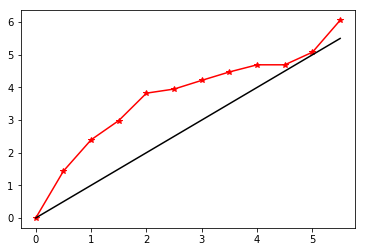

In [40]:
plt.plot(radius, Lr, 'r*-')
plt.plot(radius, radius, 'k-')
plt.show()

In [43]:
# Finding g(r), 1/(2*pi*r)*dk(r)/dr

In [41]:
gr = []

for i in range(1, len(radius)):
    dkr = (Kr[i] - Kr[i-1]) / (radius[i] - radius[i-1])
    #print (dkr)
    gr.append(dkr / (2 * np.pi * radius[i]))
gr = np.array(gr)
print (gr)

[ 4.13  3.67  2.11  2.86  0.39  0.73  0.64  0.5   0.    0.76  1.98]


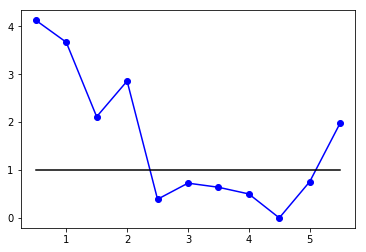

In [42]:
plt.plot(radius[1:len(radius)], gr, 'bo-')
plt.plot(radius[1:len(radius)], np.ones(len(gr)), 'k-')
plt.show()